In [59]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим данные из csv файла в DataFrame и отберем их

In [60]:
dataframe = pd.read_csv('data.csv')
dataframe.head()

,sum_data,max_pkt,pkt_count,avg_pkt,flow_speed,pkt_speed,delta_med,delta_min,status
0,5068074.0,8760.0,1278.0,3965.629108,1.013587e+06,255.593016,0.000566,2.384186e-07,0.0
1,11931634.0,8760.0,2181.0,5470.717102,2.364582e+06,432.225320,0.000707,2.384186e-07,0.0
2,10780930.0,8760.0,2027.0,5318.663049,2.141800e+06,402.695129,0.000622,2.384186e-07,0.0
3,9932642.0,8760.0,1924.0,5162.495842,1.986272e+06,384.750392,0.000656,2.384186e-07,0.0
4,13326703.0,8760.0,2336.0,5704.924229,2.602427e+06,456.172115,0.000704,2.384186e-07,0.0


При отборе данных для "имитации" пользовательской нагрузки использовался Apache-Jemeter, шаблон запросов представлен в файле requests.jmx 

Либо лично я не смог найти как изменить межпакетный интервал, либо же данная функция не предусмотрена, параметр delta_min при обучении мы опустим, тк на всех данных он равен одному значению.
Можно конечно было попробовать изменить его значение на рандомное, исходя из delta_med, однако пока что обойдемся без этого.
Также проблемы могут возникнуть с значениями столбца max_pkt, хоть при сборе статистики файл шаблонных запросов менялся(примерно раз в 1-2 часа), данные сильно повторяются, пока что этот параметр оставим, но в дальнейшем попробуем проэксперементировать с этим параметром.

In [61]:
del dataframe['delta_min'] 

<BarContainer object of 7 artists>

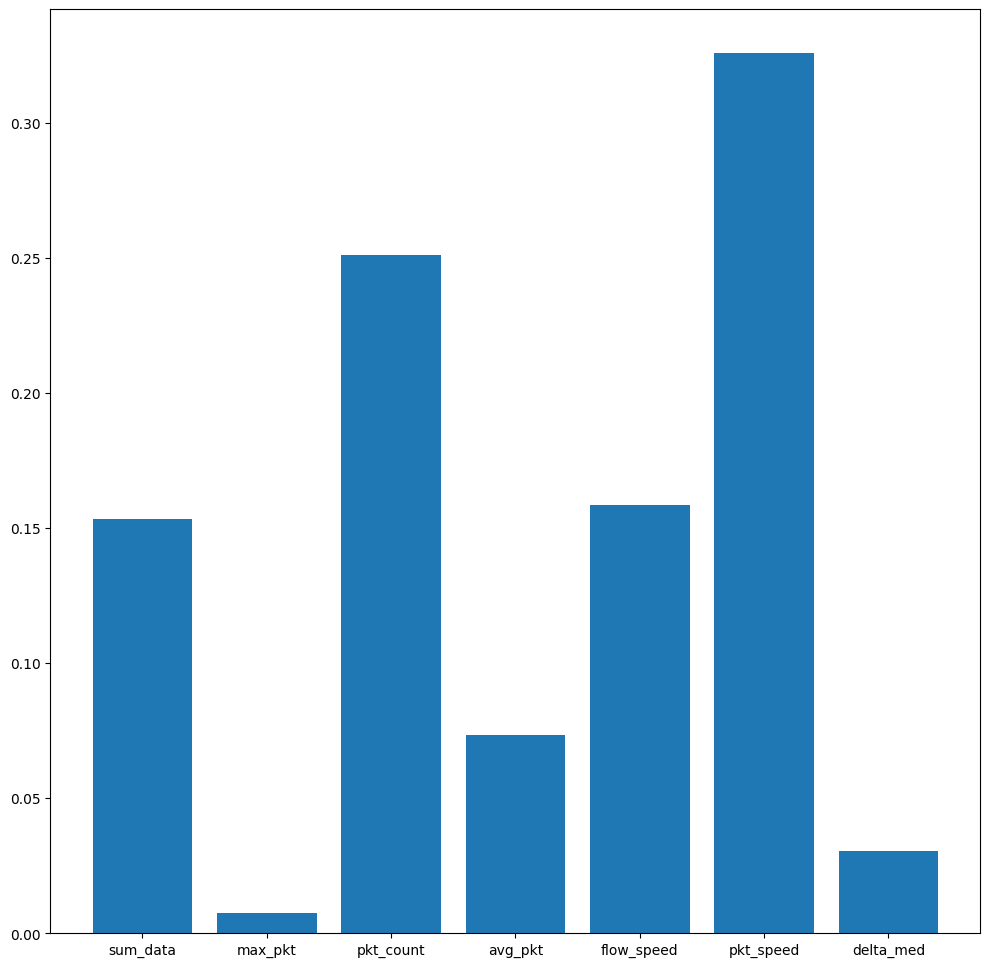

In [62]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
X = dataframe[['sum_data','max_pkt','pkt_count','avg_pkt','flow_speed','pkt_speed','delta_med']].copy()
y = dataframe['status'].copy()
clf.fit(X, y)
plt.figure(figsize=(12,12))
plt.bar(X.columns, clf.feature_importances_)

Заметим, что в нашем случае параметры msx_pkt и delta_med оказывают наименьшее влияние

In [63]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1111)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [64]:
from sklearn.model_selection import GridSearchCV
n_estimators = [300,500,700]
max_features = ['sqrt']
max_depth = [2,3,7,11,15]
min_samples_split = [2,3,4,22,23,24]
min_samples_leaf = [2,3,4,5,6,7]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [65]:
rfc = RandomForestClassifier()
rfc.fit(X_train.values, y_train.values) # удалить и раскомментировать GridSearch

RandomForestClassifier()

Займемся поиском наилучших гиперпараметров для нашей модели.(Закомментировал тк на моем пк поиск занимает большое время. При полном запуске программы необходимо раскомментировать)

In [66]:
# gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_train.values, y_train.values)
# rfc = gs.best_estimator_ 
# print(gs.best_params_)

In [67]:
from sklearn.metrics import f1_score
y_pred = rfc.predict(X_test.values)
f1_score(y_pred, y_test)

0.9989528795811519

Видим, что оценка модели по f1 мере составляет 99-100%, что очевидно является показателем странным. Возможно имеет место переобучение, однако когда я проводил обучение на меньших объемах данных, увеличивал тестовую выборку, результат не менялся, поэтому делаю вывод: дело в данных. Хоть набор и показывает себя хорошо на "искуственных" данных, он нерепрезентативен для настоящей задачи.

In [68]:
correct_pred_norma = correct_pred_atk = 0
issue_pred_norma = []
issue_pred_atk = []
for i in range(len(y_test)):
    if y_test.values[i] == y_pred[i] == 0:
        correct_pred_norma += 1
    elif y_test.values[i] == y_pred[i] == 1:
        correct_pred_atk += 1
    elif y_test.values[i] != y_pred[i]:
        (issue_pred_atk if y_pred[i] == 0 else issue_pred_norma).append(i)

Собираем в цикле информацию о количестве верных предсказаний атак и нормы, ошибки разделяем на два типа: ошибка при записи нормы, ошибка при записи атаки, сохраняем их id и сами данные


Соберем trainset

In [69]:
trainset = X_test.copy()
trainset.insert(loc=7, column='status', value=y_test.values)
trainset.insert(loc=8, column='predict', value=y_pred)
trainset.head()

,sum_data,max_pkt,pkt_count,avg_pkt,flow_speed,pkt_speed,delta_med,status,predict
10728,4843821.0,1480.0,5318.0,910.835088,9.679549e+05,1062.711431,2.508163e-04,1.0,1.0
12067,5758885.0,1480.0,5697.0,1010.862735,1.150978e+06,1138.609383,1.680851e-04,1.0,1.0
13485,117317.0,900.0,6007.0,19.530048,2.342869e+04,1199.622719,4.768372e-07,1.0,1.0
11655,5546972.0,1480.0,6025.0,920.659253,1.109237e+06,1204.828510,1.183748e-04,1.0,1.0
9979,27926.0,1297.0,407.0,68.614251,5.528200e+03,80.569263,2.329350e-04,0.0,0.0


In [70]:
indexs = issue_pred_atk + issue_pred_norma
incorrect_predictions = trainset.iloc[indexs].copy()
incorrect_predictions

,sum_data,max_pkt,pkt_count,avg_pkt,flow_speed,pkt_speed,delta_med,status,predict
12651,457411.0,1000.0,869.0,526.364787,8.978646e+04,170.578392,0.000666,1.0,0.0
62,14958592.0,8760.0,2675.0,5591.997009,2.945307e+06,526.700460,0.000576,0.0,1.0


Эту часть сделал для того, чтобы была возможность работы с данными, в предсказании которых модель совершила ошибки  

In [71]:
report_data = {
    'Total': len(trainset),
    'Norma detect': correct_pred_norma,
    'Attack detect': correct_pred_atk,
    'Issues norma predict': len(issue_pred_norma),
    'Issues attack predict': len(issue_pred_atk),
}
report_data

{'Total': 4125,
 'Norma detect': 3169,
 'Attack detect': 954,
 'Issues norma predict': 1,
 'Issues attack predict': 1}

Сделал словарь report_data для формирования отчета и построения графика

<BarContainer object of 5 artists>

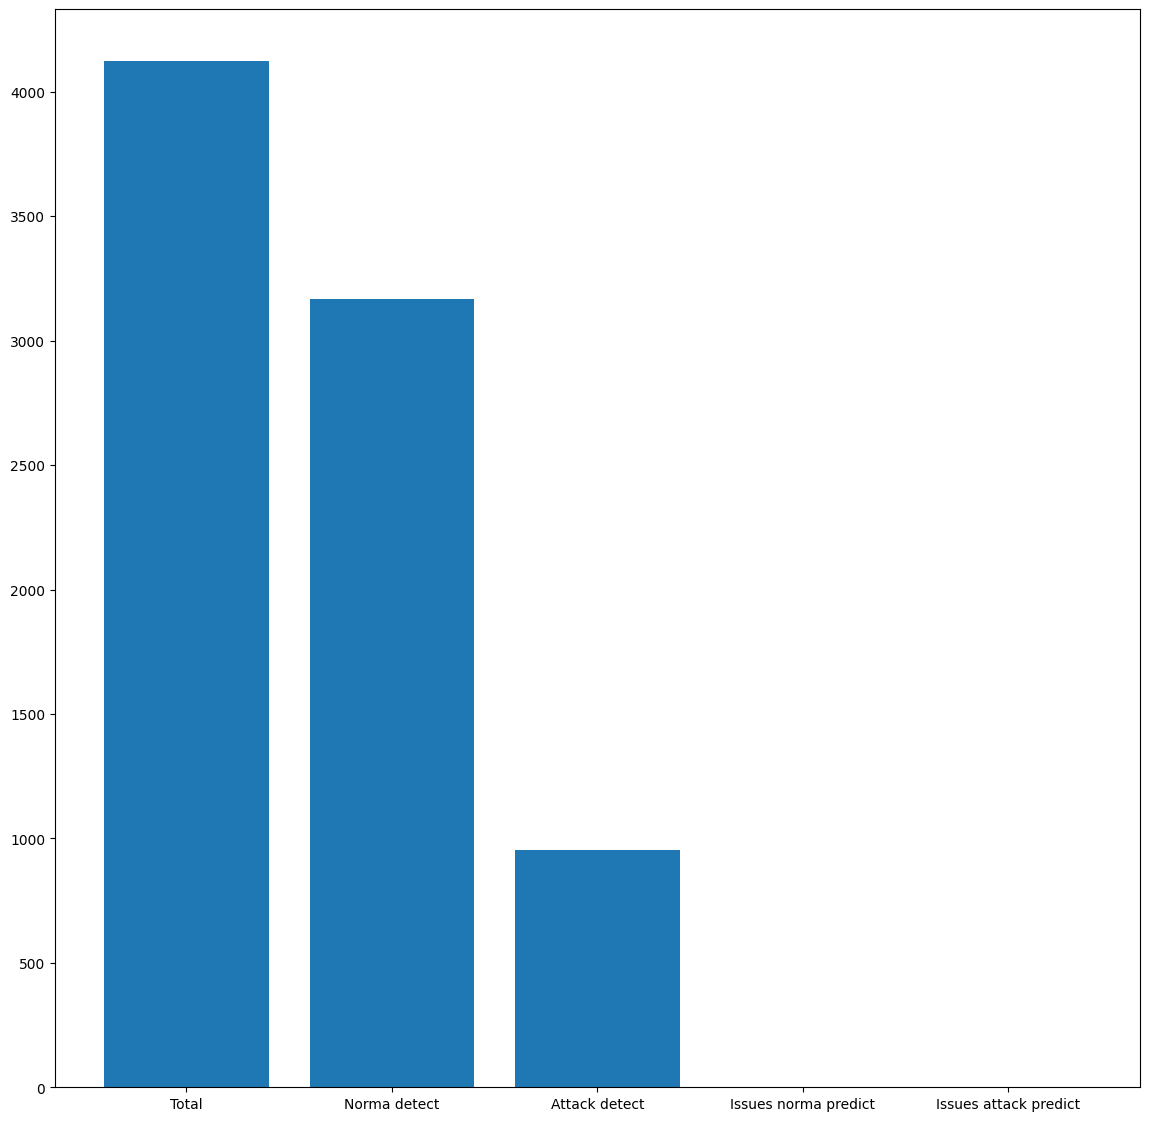

In [72]:
plt.figure(figsize=(14,14))
plt.bar(report_data.keys(), report_data.values())

In [73]:
report_frame = pd.DataFrame.from_dict(report_data, orient='index').T
report_frame.to_csv('report.csv')
report_frame

,Total,Norma detect,Attack detect,Issues norma predict,Issues attack predict
0,4125,3169,954,1,1


In [74]:
import joblib 
# joblib.dump(rfc, 'model1.pkl') 

Сохраним полученную модель. Не хотел перезаписывать файл исходной модели, нужно раскомменировать 